Imports

In [1]:
!pip install scikit-learn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [3]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu118
0.17.1+cu118


In [4]:
!pip3 install torch

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [5]:
!pip install pandas

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [6]:
import pandas as pd #For reading csv files.
import numpy as np
import os
import matplotlib.pyplot as plt #For plotting.
import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader #For working with data.
from torchvision import models,transforms #For pretrained models,image transformations.
from torch.optim.lr_scheduler import StepLR

#manual seed for reproductivity and potential performance improvement
torch.manual_seed(3407)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


In [8]:
path = "/root/autodl-tmp/"

#label csv
all_df = pd.read_csv(f"{path}allLabels.csv")

from sklearn.model_selection import train_test_split
# subset for hyperparameters tuning

part = 0.80
train_df, drop_df = train_test_split(all_df, test_size=part, random_state=42)
test_sample_size = round(7000 * (1 - part) )  #roughtly 1/3
train_df, test_df = train_test_split(train_df, test_size=test_sample_size, random_state=42)

# Assuming train_df is your original training DataFrame
# test_sample_size = 7000 # roughtly 1/3
# train_df, test_df = train_test_split(all_df, test_size=test_sample_size, random_state=42)

# Now split the remaining training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f'No.of.training_samples: {len(train_df)}')
print(f'No.of.testing_samples: {len(test_df)}')
print(f'No.of.val_samples: {len(valid_df)}')

No.of.training_samples: 5062
No.of.testing_samples: 1400
No.of.val_samples: 563


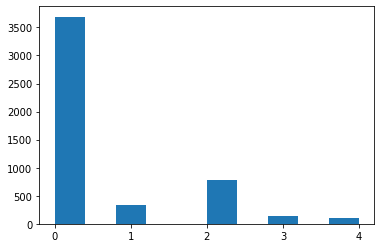

{0: 3691, 2: 777, 1: 340, 3: 146, 4: 108}
3691


In [9]:
#Histogram of label counts.
train_df.level.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show()

class_counts = train_df['level'].value_counts().to_dict()
print(class_counts)

majority_class_count = max(class_counts.values())
print(majority_class_count)

In [10]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['level'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

print(class_weights) #Prints the calculated weights for the classes.

tensor([0.2743, 2.9776, 1.3030, 6.9342, 9.3741], device='cuda:0')


In [11]:
from torchvision.transforms import functional as F
import random

class Augmenter:
    def __init__(self, rotate=True, flip_lr=True, flip_tb=True):
        self.rotate = rotate
        self.flip_lr = flip_lr
        self.flip_tb = flip_tb

    def __call__(self, img):
        if self.rotate:
            img = img.rotate(random.uniform(-25, 25))
        if self.flip_lr and random.random() > 0.5:
            img = F.hflip(img)
        if self.flip_tb and random.random() > 0.5:
            img = F.vflip(img)
        return img

augmenter = Augmenter()

In [12]:
from torchvision.transforms import functional as F
from PIL import Image
import random
import numpy as np

class AugmenterAGG:
    def __init__(self, rotate=True, flip_lr=True, flip_tb=True, translate=True):
        self.rotate = rotate
        self.flip_lr = flip_lr
        self.flip_tb = flip_tb
        self.translate = translate

    def __call__(self, img):
        if self.rotate:
            img = img.rotate(random.uniform(0, 90))
        if self.flip_lr and random.random() > 0.5:
            img = F.hflip(img)
        if self.flip_tb and random.random() > 0.5:
            img = F.vflip(img)
        if self.translate:
            img = F.affine(img, 0, (random.randint(-30, 30), random.randint(-30, 30)), 1, 0)
        return img

augmenter_agg = AugmenterAGG()


In [13]:
class dataset(Dataset):
    def __init__(self,df,data_path,image_transform=None,augment_transform=None,augment_transform_agg=None,train=True):
        super(Dataset,self).__init__()
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.augment_transform = augment_transform
        self.augment_transform_agg = augment_transform_agg
        self.train = train
        self.minority_classes = [1, 3, 4]  # specify minority classes

    def __len__(self):
        return len(self.df)

    def __getitem__(self,index):
        image_id = self.df['image'][index]
        image = Image.open(f'{self.data_path}/{image_id}.jpeg')
        label = self.df['level'][index] if self.train else None

        if self.train and self.augment_transform and label == 2:
            image = self.augment_transform_agg(image)
        if self.train and self.augment_transform and label in self.minority_classes:
            image = self.augment_transform(image)

        if self.image_transform:
            image = self.image_transform(image)

        return (image, label) if self.train else image

In [14]:
image_transform = transforms.Compose([
    transforms.Resize([512,512]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Create the datasets
train_set = dataset(train_df, f'{path}train', image_transform=image_transform, augment_transform=augmenter, augment_transform_agg=augmenter_agg)
test_set = dataset(test_df, f'{path}train', image_transform=image_transform)
valid_set = dataset(valid_df, f'{path}train', image_transform=image_transform)

In [15]:
train_dataloader = DataLoader(train_set,batch_size=16,shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_set,batch_size=16,shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=0)

In [16]:
from torchvision.models import resnet50,ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.DEFAULT) #Downloads the resnet50 model which is pretrained on Imagenet dataset.
# Replace the Final layer of pretrained resnet50
model.fc = nn.Sequential(
    nn.Linear(2048, 5),
)
model = model.to(device) #Moves the model to the device.

In [17]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.

    total = 0
    correct = 0
    running_loss = 0

    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.


        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.

        running_loss += loss.item()

        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        accuracy = 100*(correct/total)

        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.

        #for memory
        torch.cuda.empty_cache()

        # Print some information every 100 batches
        if batch % 70 == 0:
            print(f'Batch {batch}/{len(dataloader)} processed, running loss: {running_loss:.6f}, correct predictions: {correct}, total: {total}')


    avg_loss = running_loss/len(dataloader) # Average loss for a single batch

    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    torch.save(model, 'aug_fix.pt')
    return avg_loss, accuracy

In [18]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.eval() #Sets the model for evaluation.

    total = 0
    correct = 0
    running_loss = 0

    with torch.no_grad(): #No need to calculate the gradients.

        for x,y in dataloader:

            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss

            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            accuracy = 100*(correct/total)

    avg_loss = running_loss/len(dataloader) #Average loss per batch.

    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    return avg_loss, accuracy

In [19]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'g', label='Training Loss')
    plt.plot(epochs, valid_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'g', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [20]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.

    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.

    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    # Initialize the learning rate scheduler
    # scheduler = StepLR(optimizer, step_size=4, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

    best_valid_loss = float('inf')
    no_improve_epoch = 0

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        print("Epoch: %d, Learning Rate: %f " % (epoch, optimizer.param_groups[0]['lr']))
        train_loss, train_accuracy = train(train_dataloader,model,loss_fn,optimizer)
        valid_loss, valid_accuracy = validate(valid_dataloader,model,loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

        plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies)


        # Check if the validation loss improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improve_epoch = 0

            # Save the model when validation loss improves
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improve_epoch += 1

        # If the validation loss did not improve for 'patience' epochs, stop training
        if no_improve_epoch >= patience:
            print(f'Early stopping at epoch {epoch+1}, the validation loss did not improve for the last {patience} epochs')

            # Save to CSV
            df.to_csv('res.csv', index=False)
            break

        # Step the learning rate scheduler
        # scheduler.step()
        scheduler.step(valid_loss)

        df = pd.concat([df, pd.DataFrame({'epoch': [epoch+1], 'train_loss': [train_loss], 'train_accuracy': [train_accuracy], 'valid_loss': [valid_loss], 'valid_accuracy': [valid_accuracy]})], ignore_index=True)

    print('\nTraining has completed!')

    # Save to CSV
    df.to_csv('training_validation_metrics.csv', index=False)

    return train_losses,valid_losses


Epoch 1/50
-------------------------------
Epoch: 0, Learning Rate: 0.001000 
Batch 0/317 processed, running loss: 1.660634, correct predictions: 1, total: 16
Batch 70/317 processed, running loss: 118.407400, correct predictions: 309, total: 1136
Batch 140/317 processed, running loss: 232.068861, correct predictions: 645, total: 2256
Batch 210/317 processed, running loss: 344.186382, correct predictions: 1263, total: 3376
Batch 280/317 processed, running loss: 457.416782, correct predictions: 1958, total: 4496

Training Loss per batch = 1.626584	Accuracy on Training set = 46.029237% [2330/5062]

Validation Loss per batch = 1.603522	Accuracy on Validation set = 66.252220% [373/563]
Train Loss: 1.6266, Train Accuracy: 46.0292
Valid Loss: 1.6035, Valid Accuracy: 66.2522


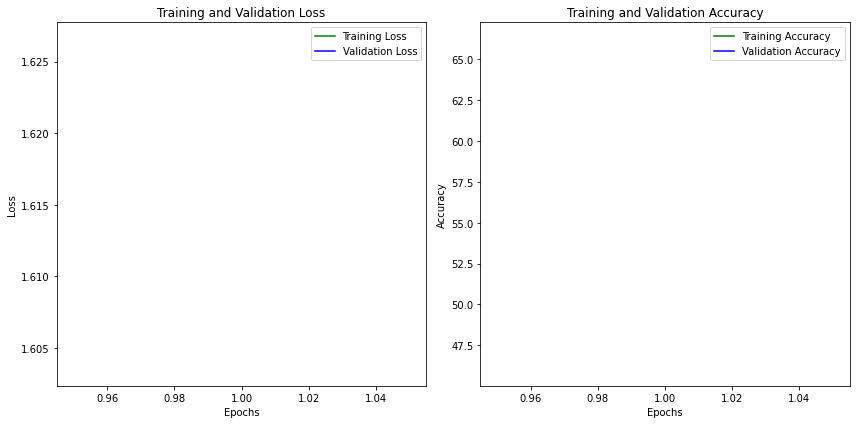


Epoch 2/50
-------------------------------
Epoch: 1, Learning Rate: 0.001000 
Batch 0/317 processed, running loss: 1.725287, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 114.293824, correct predictions: 646, total: 1136
Batch 140/317 processed, running loss: 226.288417, correct predictions: 1331, total: 2256
Batch 210/317 processed, running loss: 338.830436, correct predictions: 2086, total: 3376
Batch 280/317 processed, running loss: 450.665663, correct predictions: 2865, total: 4496

Training Loss per batch = 1.607794	Accuracy on Training set = 62.643224% [3171/5062]

Validation Loss per batch = 1.594044	Accuracy on Validation set = 68.561279% [386/563]
Train Loss: 1.6078, Train Accuracy: 62.6432
Valid Loss: 1.5940, Valid Accuracy: 68.5613


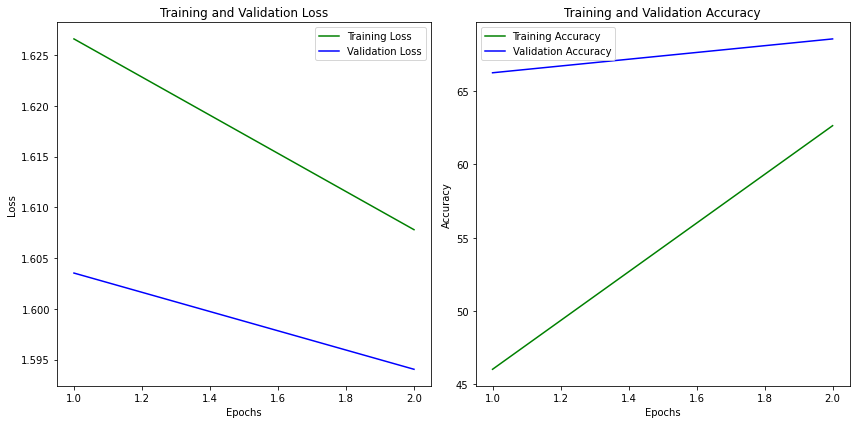


Epoch 3/50
-------------------------------
Epoch: 2, Learning Rate: 0.001000 
Batch 0/317 processed, running loss: 1.570204, correct predictions: 8, total: 16
Batch 70/317 processed, running loss: 114.409268, correct predictions: 776, total: 1136
Batch 140/317 processed, running loss: 226.895525, correct predictions: 1534, total: 2256
Batch 210/317 processed, running loss: 338.838265, correct predictions: 2354, total: 3376
Batch 280/317 processed, running loss: 451.192270, correct predictions: 3166, total: 4496

Training Loss per batch = 1.604266	Accuracy on Training set = 69.715527% [3529/5062]

Validation Loss per batch = 1.568571	Accuracy on Validation set = 71.403197% [402/563]
Train Loss: 1.6043, Train Accuracy: 69.7155
Valid Loss: 1.5686, Valid Accuracy: 71.4032


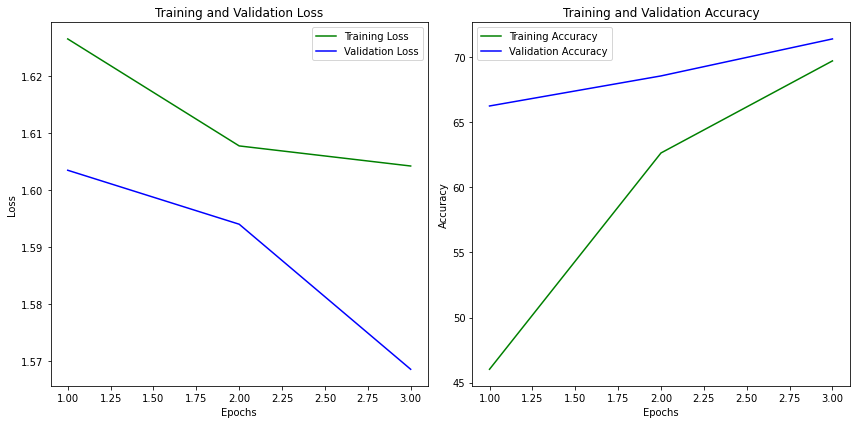


Epoch 4/50
-------------------------------
Epoch: 3, Learning Rate: 0.001000 
Batch 0/317 processed, running loss: 1.483740, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 112.612811, correct predictions: 806, total: 1136
Batch 140/317 processed, running loss: 224.881620, correct predictions: 1585, total: 2256
Batch 210/317 processed, running loss: 336.198433, correct predictions: 2405, total: 3376
Batch 280/317 processed, running loss: 447.156275, correct predictions: 3231, total: 4496

Training Loss per batch = 1.591203	Accuracy on Training set = 70.406954% [3564/5062]

Validation Loss per batch = 1.573882	Accuracy on Validation set = 71.936057% [405/563]
Train Loss: 1.5912, Train Accuracy: 70.4070
Valid Loss: 1.5739, Valid Accuracy: 71.9361


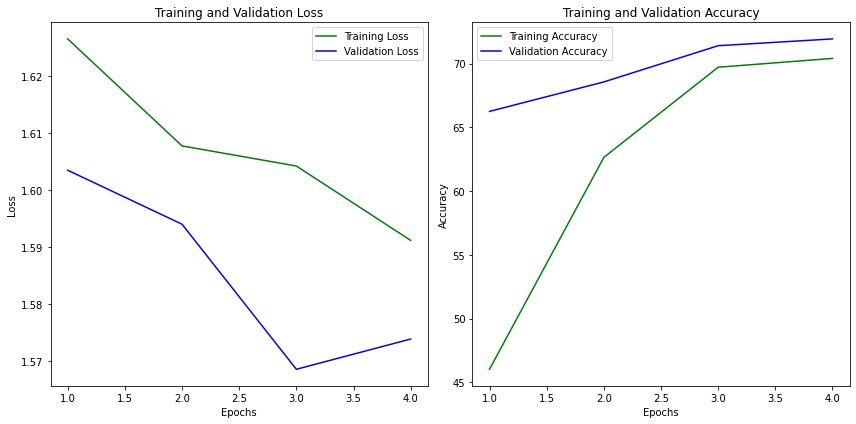


Epoch 5/50
-------------------------------
Epoch: 4, Learning Rate: 0.001000 
Batch 0/317 processed, running loss: 1.451810, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 113.648166, correct predictions: 679, total: 1136
Batch 140/317 processed, running loss: 224.032686, correct predictions: 1304, total: 2256
Batch 210/317 processed, running loss: 331.503438, correct predictions: 1916, total: 3376
Batch 280/317 processed, running loss: 443.679226, correct predictions: 2623, total: 4496

Training Loss per batch = 1.581175	Accuracy on Training set = 57.605689% [2916/5062]

Validation Loss per batch = 1.599461	Accuracy on Validation set = 50.444050% [284/563]
Train Loss: 1.5812, Train Accuracy: 57.6057
Valid Loss: 1.5995, Valid Accuracy: 50.4440


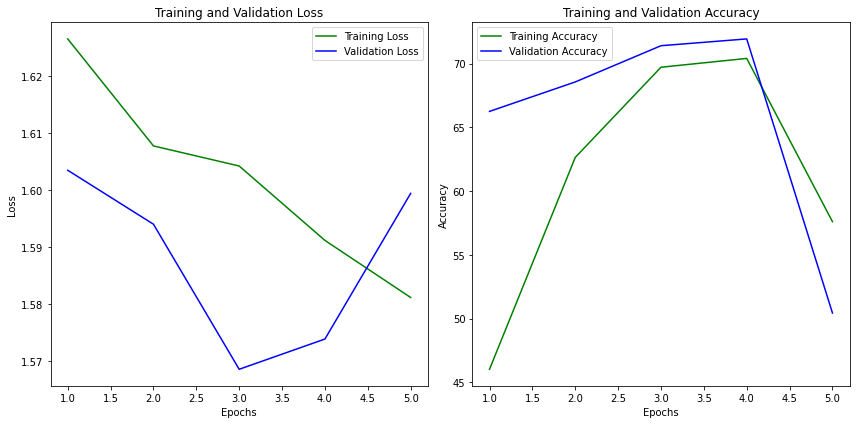


Epoch 6/50
-------------------------------
Epoch: 5, Learning Rate: 0.001000 
Batch 0/317 processed, running loss: 1.647280, correct predictions: 6, total: 16
Batch 70/317 processed, running loss: 112.538793, correct predictions: 691, total: 1136
Batch 140/317 processed, running loss: 224.492831, correct predictions: 1392, total: 2256
Batch 210/317 processed, running loss: 335.616423, correct predictions: 2012, total: 3376
Batch 280/317 processed, running loss: 448.514952, correct predictions: 2629, total: 4496

Training Loss per batch = 1.595082	Accuracy on Training set = 56.854998% [2878/5062]

Validation Loss per batch = 1.681485	Accuracy on Validation set = 27.353464% [154/563]
Train Loss: 1.5951, Train Accuracy: 56.8550
Valid Loss: 1.6815, Valid Accuracy: 27.3535


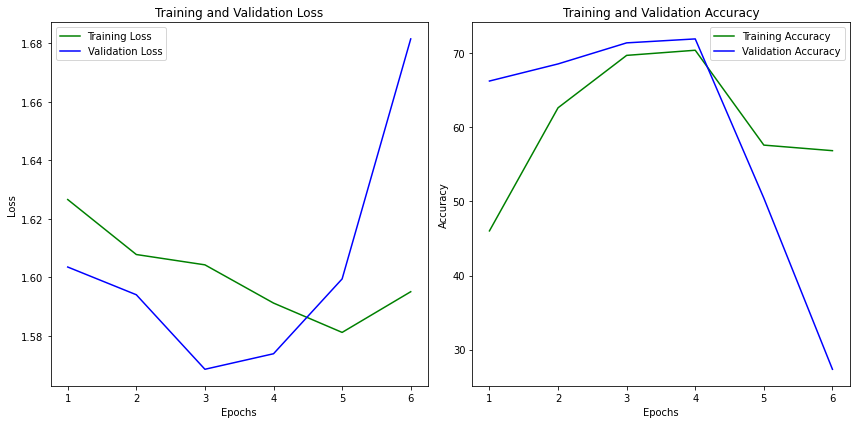


Epoch 7/50
-------------------------------
Epoch: 6, Learning Rate: 0.001000 
Batch 0/317 processed, running loss: 1.505173, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 111.633945, correct predictions: 607, total: 1136
Batch 140/317 processed, running loss: 221.417452, correct predictions: 1300, total: 2256
Batch 210/317 processed, running loss: 330.219751, correct predictions: 1975, total: 3376
Batch 280/317 processed, running loss: 439.205132, correct predictions: 2683, total: 4496

Training Loss per batch = 1.561906	Accuracy on Training set = 60.331885% [3054/5062]

Validation Loss per batch = 1.573780	Accuracy on Validation set = 58.614565% [330/563]
Train Loss: 1.5619, Train Accuracy: 60.3319
Valid Loss: 1.5738, Valid Accuracy: 58.6146


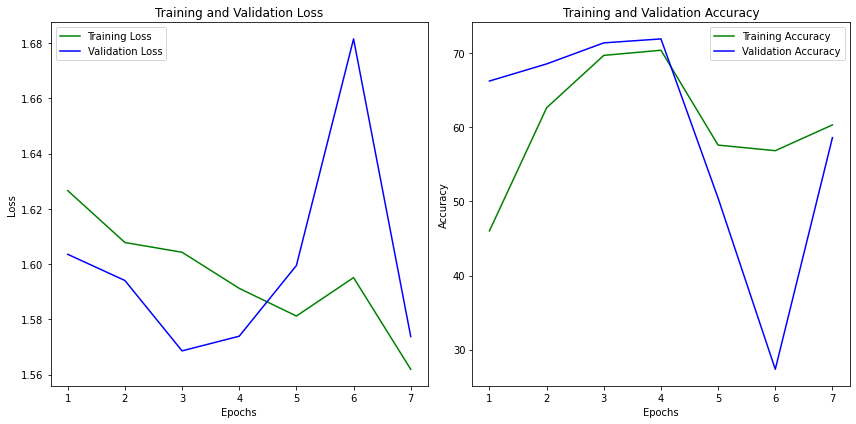


Epoch 8/50
-------------------------------
Epoch: 7, Learning Rate: 0.000100 
Batch 0/317 processed, running loss: 1.742833, correct predictions: 8, total: 16
Batch 70/317 processed, running loss: 109.711582, correct predictions: 672, total: 1136
Batch 140/317 processed, running loss: 217.478238, correct predictions: 1374, total: 2256
Batch 210/317 processed, running loss: 327.685596, correct predictions: 2097, total: 3376
Batch 280/317 processed, running loss: 433.290041, correct predictions: 2821, total: 4496

Training Loss per batch = 1.540756	Accuracy on Training set = 62.821019% [3180/5062]

Validation Loss per batch = 1.579816	Accuracy on Validation set = 59.502664% [335/563]
Train Loss: 1.5408, Train Accuracy: 62.8210
Valid Loss: 1.5798, Valid Accuracy: 59.5027


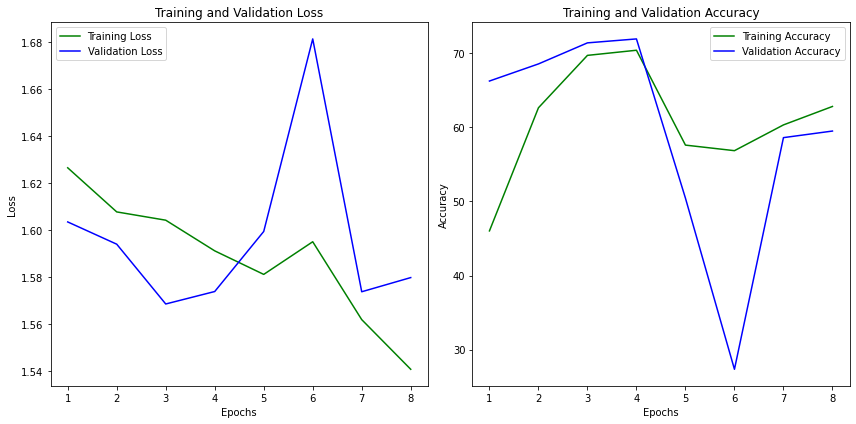


Epoch 9/50
-------------------------------
Epoch: 8, Learning Rate: 0.000100 
Batch 0/317 processed, running loss: 1.573809, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 108.594762, correct predictions: 781, total: 1136
Batch 140/317 processed, running loss: 215.722458, correct predictions: 1536, total: 2256
Batch 210/317 processed, running loss: 323.305271, correct predictions: 2268, total: 3376
Batch 280/317 processed, running loss: 429.323771, correct predictions: 3019, total: 4496

Training Loss per batch = 1.534527	Accuracy on Training set = 67.107863% [3397/5062]

Validation Loss per batch = 1.584541	Accuracy on Validation set = 68.383659% [385/563]
Train Loss: 1.5345, Train Accuracy: 67.1079
Valid Loss: 1.5845, Valid Accuracy: 68.3837


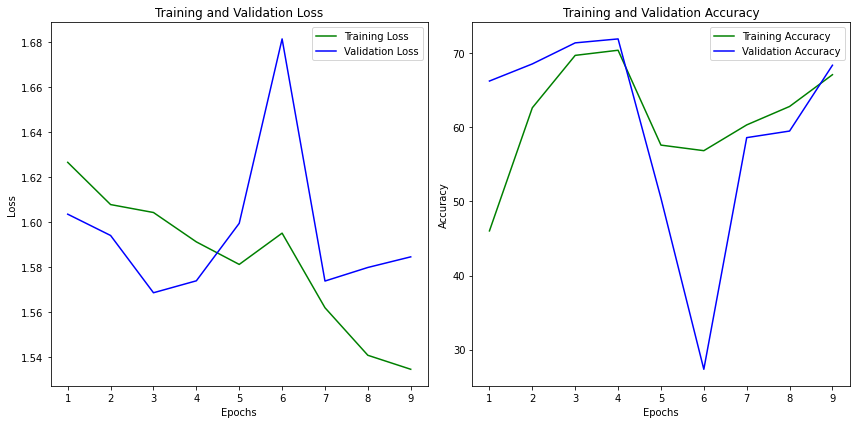


Epoch 10/50
-------------------------------
Epoch: 9, Learning Rate: 0.000100 
Batch 0/317 processed, running loss: 2.201600, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 108.083510, correct predictions: 784, total: 1136
Batch 140/317 processed, running loss: 216.052974, correct predictions: 1541, total: 2256
Batch 210/317 processed, running loss: 323.360356, correct predictions: 2297, total: 3376
Batch 280/317 processed, running loss: 428.786276, correct predictions: 3066, total: 4496

Training Loss per batch = 1.524958	Accuracy on Training set = 68.214145% [3453/5062]

Validation Loss per batch = 1.582618	Accuracy on Validation set = 61.101243% [344/563]
Train Loss: 1.5250, Train Accuracy: 68.2141
Valid Loss: 1.5826, Valid Accuracy: 61.1012


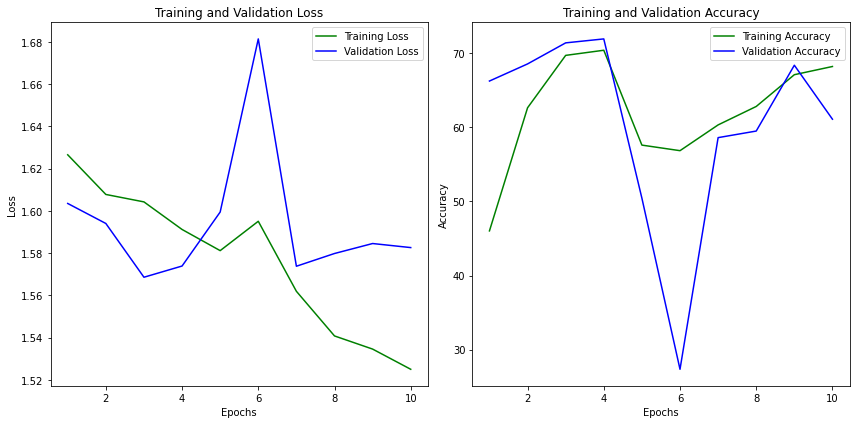


Epoch 11/50
-------------------------------
Epoch: 10, Learning Rate: 0.000100 
Batch 0/317 processed, running loss: 1.595128, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 108.677040, correct predictions: 785, total: 1136
Batch 140/317 processed, running loss: 212.108669, correct predictions: 1579, total: 2256
Batch 210/317 processed, running loss: 316.183403, correct predictions: 2334, total: 3376
Batch 280/317 processed, running loss: 422.733704, correct predictions: 3098, total: 4496

Training Loss per batch = 1.504343	Accuracy on Training set = 68.727776% [3479/5062]

Validation Loss per batch = 1.610549	Accuracy on Validation set = 71.047957% [400/563]
Train Loss: 1.5043, Train Accuracy: 68.7278
Valid Loss: 1.6105, Valid Accuracy: 71.0480


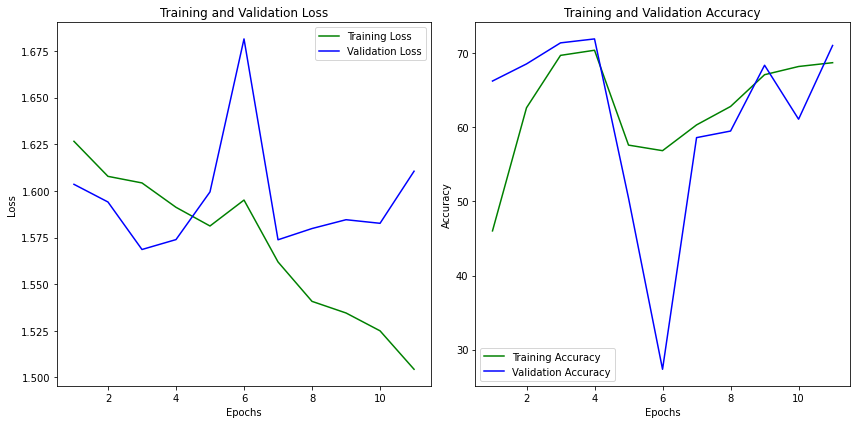


Epoch 12/50
-------------------------------
Epoch: 11, Learning Rate: 0.000010 
Batch 0/317 processed, running loss: 1.623052, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 106.220743, correct predictions: 783, total: 1136
Batch 140/317 processed, running loss: 212.425580, correct predictions: 1560, total: 2256
Batch 210/317 processed, running loss: 316.454538, correct predictions: 2354, total: 3376
Batch 280/317 processed, running loss: 421.333049, correct predictions: 3141, total: 4496

Training Loss per batch = 1.506270	Accuracy on Training set = 69.932833% [3540/5062]

Validation Loss per batch = 1.606760	Accuracy on Validation set = 69.626998% [392/563]
Train Loss: 1.5063, Train Accuracy: 69.9328
Valid Loss: 1.6068, Valid Accuracy: 69.6270


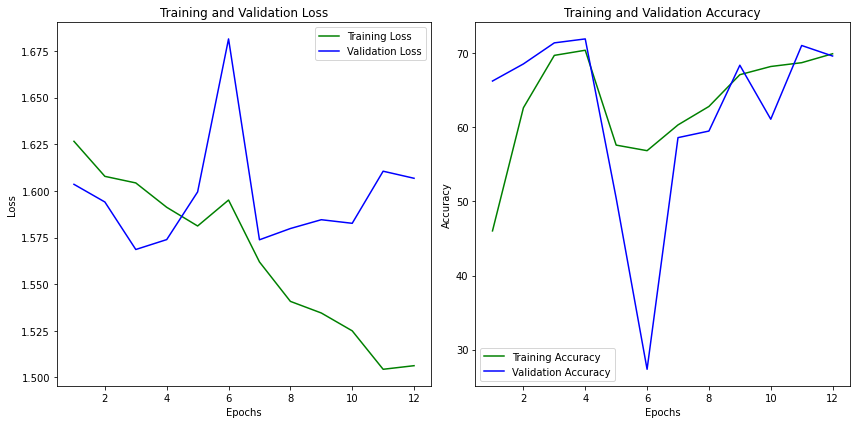


Epoch 13/50
-------------------------------
Epoch: 12, Learning Rate: 0.000010 
Batch 0/317 processed, running loss: 1.540725, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 104.357344, correct predictions: 821, total: 1136
Batch 140/317 processed, running loss: 210.115571, correct predictions: 1612, total: 2256
Batch 210/317 processed, running loss: 316.788294, correct predictions: 2403, total: 3376
Batch 280/317 processed, running loss: 422.977582, correct predictions: 3196, total: 4496

Training Loss per batch = 1.505380	Accuracy on Training set = 71.256420% [3607/5062]

Validation Loss per batch = 1.603208	Accuracy on Validation set = 65.186501% [367/563]
Train Loss: 1.5054, Train Accuracy: 71.2564
Valid Loss: 1.6032, Valid Accuracy: 65.1865


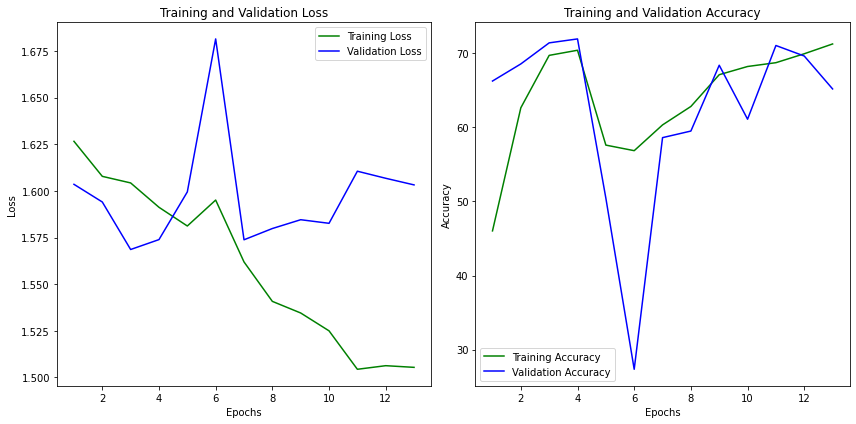


Epoch 14/50
-------------------------------
Epoch: 13, Learning Rate: 0.000010 
Batch 0/317 processed, running loss: 1.074876, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 105.550047, correct predictions: 800, total: 1136
Batch 140/317 processed, running loss: 211.057983, correct predictions: 1600, total: 2256
Batch 210/317 processed, running loss: 316.526480, correct predictions: 2404, total: 3376
Batch 280/317 processed, running loss: 421.413858, correct predictions: 3197, total: 4496

Training Loss per batch = 1.497932	Accuracy on Training set = 71.078625% [3598/5062]

Validation Loss per batch = 1.609921	Accuracy on Validation set = 70.870337% [399/563]
Train Loss: 1.4979, Train Accuracy: 71.0786
Valid Loss: 1.6099, Valid Accuracy: 70.8703


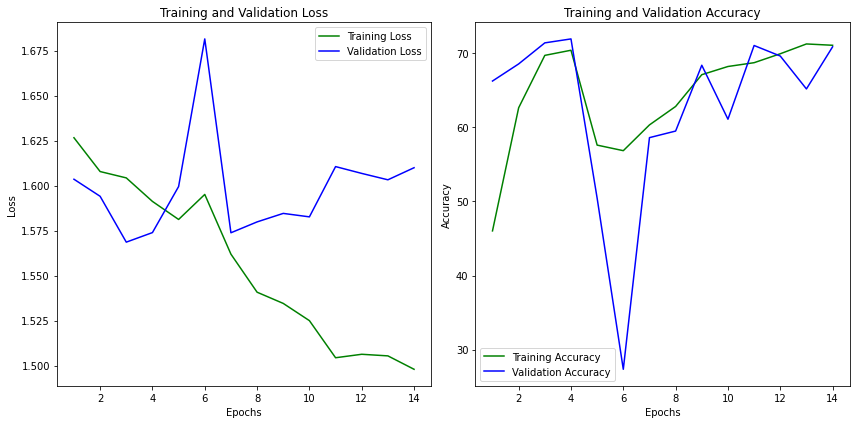


Epoch 15/50
-------------------------------
Epoch: 14, Learning Rate: 0.000010 
Batch 0/317 processed, running loss: 1.471628, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 103.911069, correct predictions: 806, total: 1136
Batch 140/317 processed, running loss: 208.881532, correct predictions: 1587, total: 2256
Batch 210/317 processed, running loss: 316.128657, correct predictions: 2375, total: 3376
Batch 280/317 processed, running loss: 421.833520, correct predictions: 3176, total: 4496

Training Loss per batch = 1.501648	Accuracy on Training set = 70.644014% [3576/5062]

Validation Loss per batch = 1.605936	Accuracy on Validation set = 68.561279% [386/563]
Train Loss: 1.5016, Train Accuracy: 70.6440
Valid Loss: 1.6059, Valid Accuracy: 68.5613


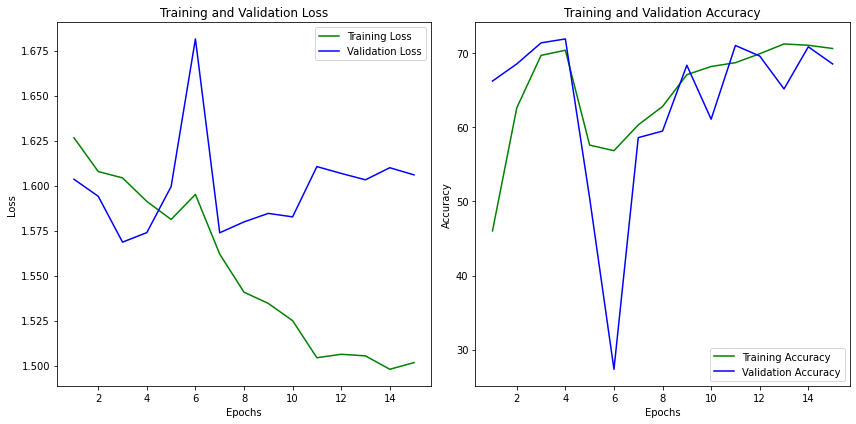


Epoch 16/50
-------------------------------
Epoch: 15, Learning Rate: 0.000001 
Batch 0/317 processed, running loss: 1.295457, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 103.679193, correct predictions: 816, total: 1136
Batch 140/317 processed, running loss: 211.874081, correct predictions: 1596, total: 2256
Batch 210/317 processed, running loss: 316.042935, correct predictions: 2397, total: 3376
Batch 280/317 processed, running loss: 420.380562, correct predictions: 3185, total: 4496

Training Loss per batch = 1.493785	Accuracy on Training set = 70.960095% [3592/5062]

Validation Loss per batch = 1.605710	Accuracy on Validation set = 68.738899% [387/563]
Train Loss: 1.4938, Train Accuracy: 70.9601
Valid Loss: 1.6057, Valid Accuracy: 68.7389


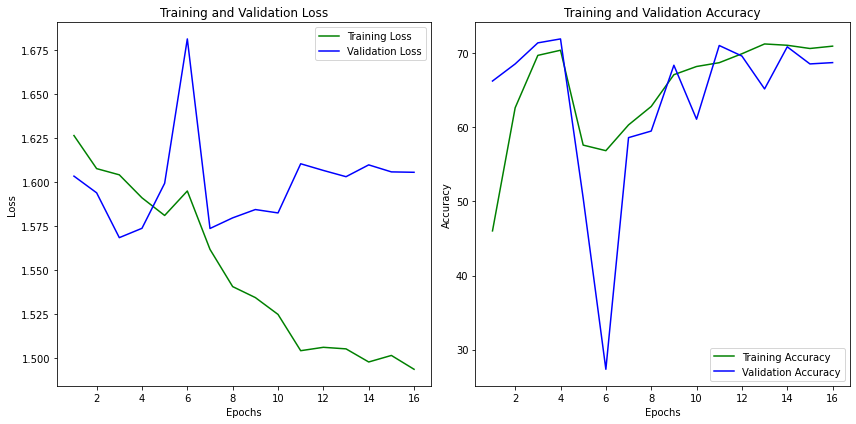


Epoch 17/50
-------------------------------
Epoch: 16, Learning Rate: 0.000001 
Batch 0/317 processed, running loss: 1.301904, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 107.838257, correct predictions: 791, total: 1136
Batch 140/317 processed, running loss: 211.637290, correct predictions: 1581, total: 2256
Batch 210/317 processed, running loss: 316.244519, correct predictions: 2378, total: 3376
Batch 280/317 processed, running loss: 419.657578, correct predictions: 3173, total: 4496

Training Loss per batch = 1.496191	Accuracy on Training set = 70.782299% [3583/5062]

Validation Loss per batch = 1.608705	Accuracy on Validation set = 69.982238% [394/563]
Train Loss: 1.4962, Train Accuracy: 70.7823
Valid Loss: 1.6087, Valid Accuracy: 69.9822


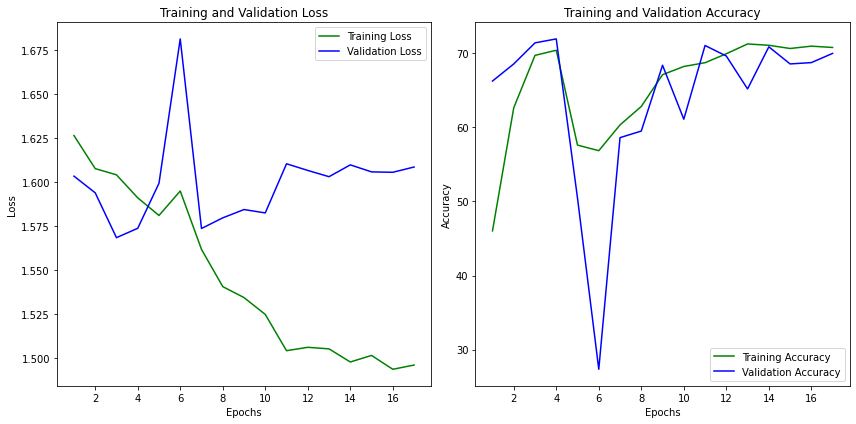


Epoch 18/50
-------------------------------
Epoch: 17, Learning Rate: 0.000001 
Batch 0/317 processed, running loss: 1.088583, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 105.274194, correct predictions: 811, total: 1136
Batch 140/317 processed, running loss: 209.236418, correct predictions: 1631, total: 2256
Batch 210/317 processed, running loss: 314.441899, correct predictions: 2435, total: 3376
Batch 280/317 processed, running loss: 419.326569, correct predictions: 3226, total: 4496

Training Loss per batch = 1.487650	Accuracy on Training set = 71.928092% [3641/5062]

Validation Loss per batch = 1.607548	Accuracy on Validation set = 69.449378% [391/563]
Train Loss: 1.4876, Train Accuracy: 71.9281
Valid Loss: 1.6075, Valid Accuracy: 69.4494


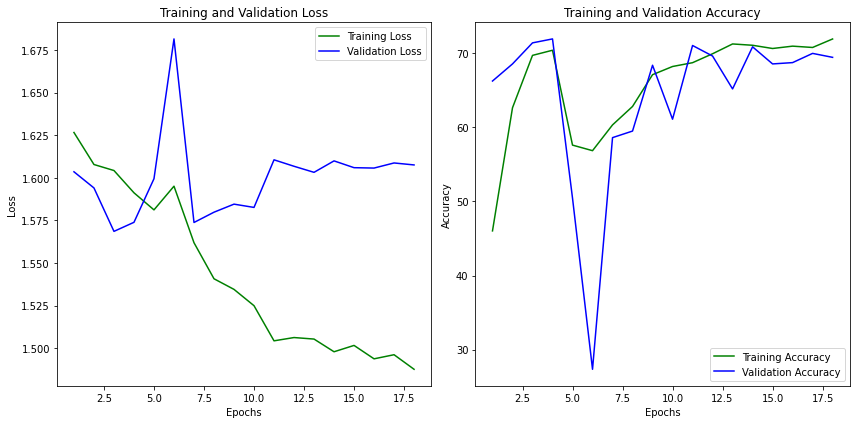


Epoch 19/50
-------------------------------
Epoch: 18, Learning Rate: 0.000001 
Batch 0/317 processed, running loss: 1.655552, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 107.245333, correct predictions: 789, total: 1136
Batch 140/317 processed, running loss: 211.376004, correct predictions: 1588, total: 2256
Batch 210/317 processed, running loss: 313.546457, correct predictions: 2388, total: 3376
Batch 280/317 processed, running loss: 417.240236, correct predictions: 3180, total: 4496

Training Loss per batch = 1.486465	Accuracy on Training set = 70.564994% [3572/5062]

Validation Loss per batch = 1.607469	Accuracy on Validation set = 66.962700% [377/563]
Train Loss: 1.4865, Train Accuracy: 70.5650
Valid Loss: 1.6075, Valid Accuracy: 66.9627


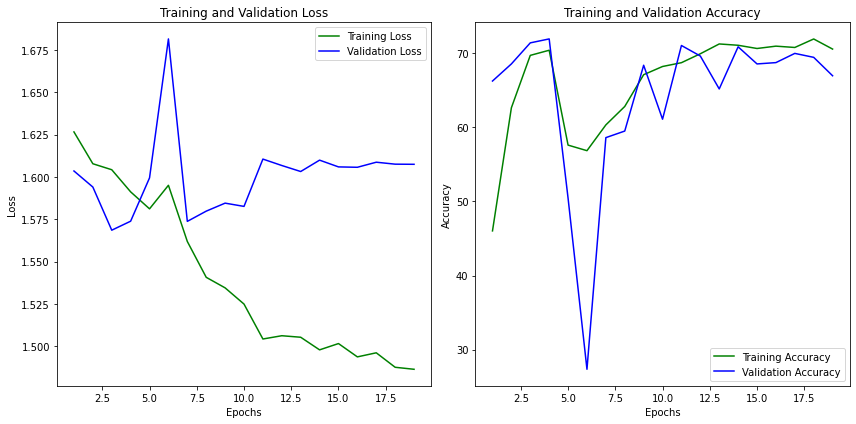


Epoch 20/50
-------------------------------
Epoch: 19, Learning Rate: 0.000000 
Batch 0/317 processed, running loss: 1.729124, correct predictions: 9, total: 16
Batch 70/317 processed, running loss: 105.862475, correct predictions: 805, total: 1136
Batch 140/317 processed, running loss: 208.701642, correct predictions: 1627, total: 2256
Batch 210/317 processed, running loss: 315.053700, correct predictions: 2423, total: 3376
Batch 280/317 processed, running loss: 420.412406, correct predictions: 3199, total: 4496

Training Loss per batch = 1.493850	Accuracy on Training set = 71.355196% [3612/5062]

Validation Loss per batch = 1.607971	Accuracy on Validation set = 69.982238% [394/563]
Train Loss: 1.4939, Train Accuracy: 71.3552
Valid Loss: 1.6080, Valid Accuracy: 69.9822


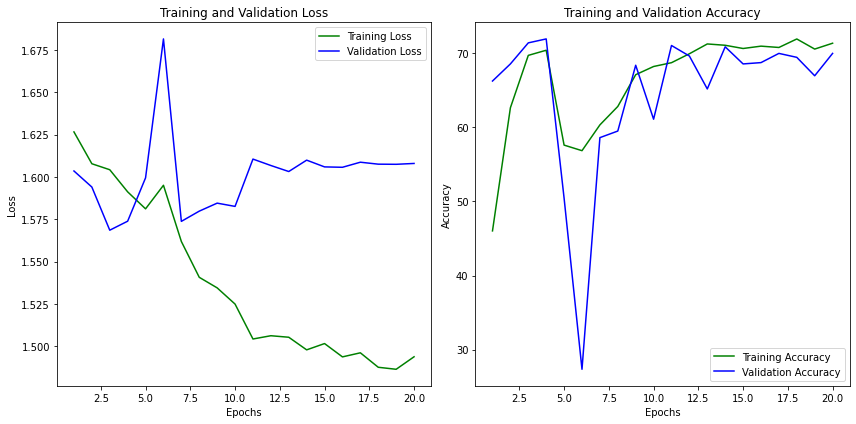


Epoch 21/50
-------------------------------
Epoch: 20, Learning Rate: 0.000000 
Batch 0/317 processed, running loss: 1.788086, correct predictions: 6, total: 16
Batch 70/317 processed, running loss: 106.429109, correct predictions: 817, total: 1136
Batch 140/317 processed, running loss: 211.504320, correct predictions: 1611, total: 2256
Batch 210/317 processed, running loss: 313.005392, correct predictions: 2425, total: 3376
Batch 280/317 processed, running loss: 418.331566, correct predictions: 3219, total: 4496

Training Loss per batch = 1.492185	Accuracy on Training set = 71.197155% [3604/5062]

Validation Loss per batch = 1.605850	Accuracy on Validation set = 67.495560% [380/563]
Train Loss: 1.4922, Train Accuracy: 71.1972
Valid Loss: 1.6058, Valid Accuracy: 67.4956


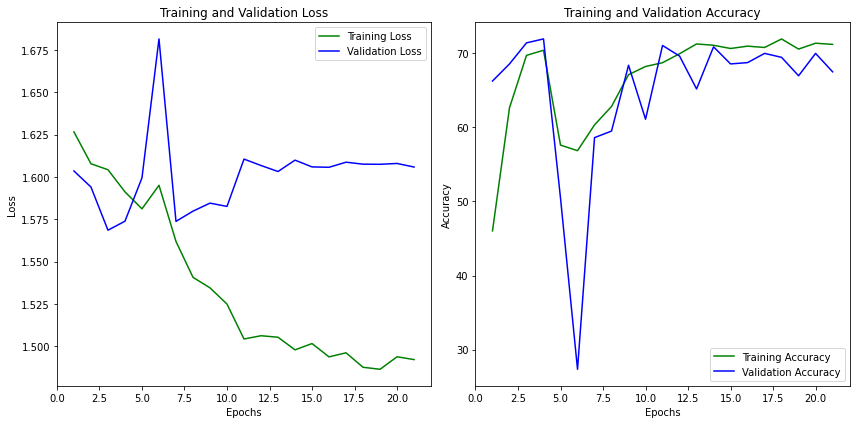


Epoch 22/50
-------------------------------
Epoch: 21, Learning Rate: 0.000000 
Batch 0/317 processed, running loss: 1.279770, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 107.354672, correct predictions: 823, total: 1136
Batch 140/317 processed, running loss: 213.580366, correct predictions: 1604, total: 2256
Batch 210/317 processed, running loss: 319.489784, correct predictions: 2372, total: 3376
Batch 280/317 processed, running loss: 422.506094, correct predictions: 3191, total: 4496

Training Loss per batch = 1.498905	Accuracy on Training set = 71.276175% [3608/5062]

Validation Loss per batch = 1.610638	Accuracy on Validation set = 71.225577% [401/563]
Train Loss: 1.4989, Train Accuracy: 71.2762
Valid Loss: 1.6106, Valid Accuracy: 71.2256


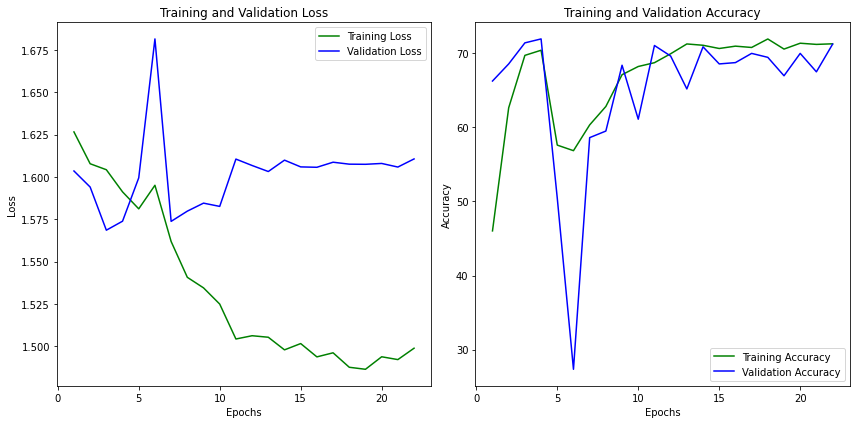


Epoch 23/50
-------------------------------
Epoch: 22, Learning Rate: 0.000000 
Batch 0/317 processed, running loss: 1.428499, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 108.583798, correct predictions: 818, total: 1136
Batch 140/317 processed, running loss: 209.952992, correct predictions: 1622, total: 2256
Batch 210/317 processed, running loss: 313.496017, correct predictions: 2400, total: 3376
Batch 280/317 processed, running loss: 418.629121, correct predictions: 3194, total: 4496

Training Loss per batch = 1.491038	Accuracy on Training set = 71.394706% [3614/5062]

Validation Loss per batch = 1.606122	Accuracy on Validation set = 67.673179% [381/563]
Train Loss: 1.4910, Train Accuracy: 71.3947
Valid Loss: 1.6061, Valid Accuracy: 67.6732


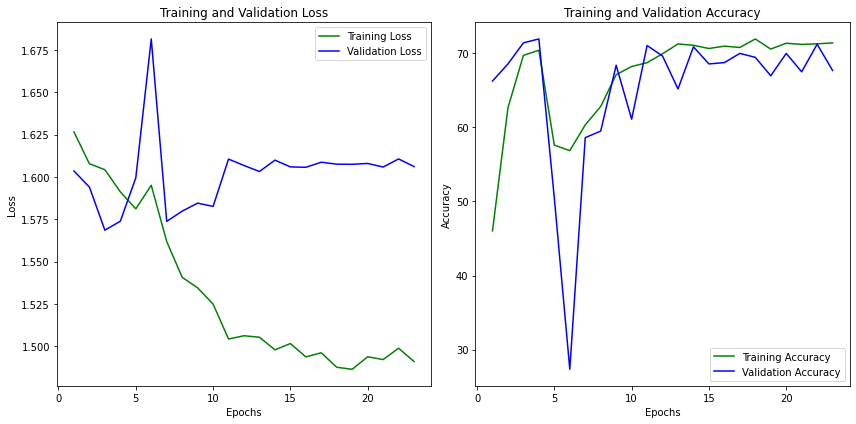


Epoch 24/50
-------------------------------
Epoch: 23, Learning Rate: 0.000000 
Batch 0/317 processed, running loss: 1.125398, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 105.138164, correct predictions: 837, total: 1136
Batch 140/317 processed, running loss: 210.396974, correct predictions: 1619, total: 2256
Batch 210/317 processed, running loss: 314.707756, correct predictions: 2412, total: 3376
Batch 280/317 processed, running loss: 419.323257, correct predictions: 3203, total: 4496

Training Loss per batch = 1.496782	Accuracy on Training set = 71.216910% [3605/5062]

Validation Loss per batch = 1.604855	Accuracy on Validation set = 66.074600% [372/563]
Train Loss: 1.4968, Train Accuracy: 71.2169
Valid Loss: 1.6049, Valid Accuracy: 66.0746


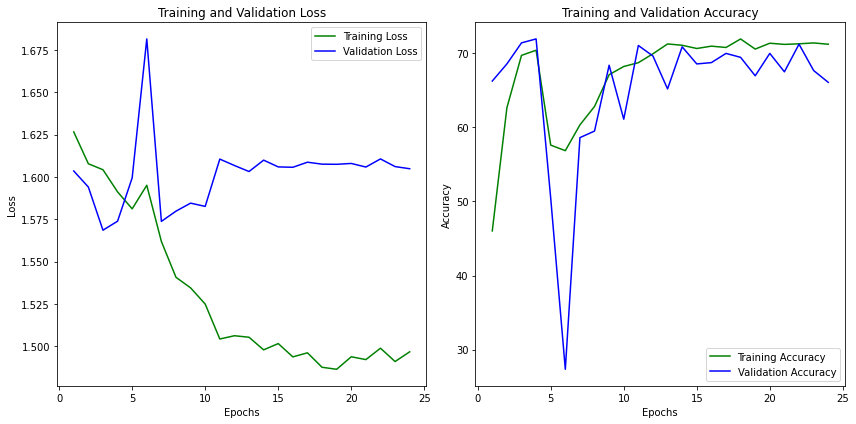


Epoch 25/50
-------------------------------
Epoch: 24, Learning Rate: 0.000000 
Batch 0/317 processed, running loss: 1.440895, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 105.078929, correct predictions: 810, total: 1136
Batch 140/317 processed, running loss: 211.831302, correct predictions: 1592, total: 2256
Batch 210/317 processed, running loss: 316.077852, correct predictions: 2412, total: 3376
Batch 280/317 processed, running loss: 419.718354, correct predictions: 3228, total: 4496

Training Loss per batch = 1.494725	Accuracy on Training set = 71.671276% [3628/5062]

Validation Loss per batch = 1.606208	Accuracy on Validation set = 69.626998% [392/563]
Train Loss: 1.4947, Train Accuracy: 71.6713
Valid Loss: 1.6062, Valid Accuracy: 69.6270


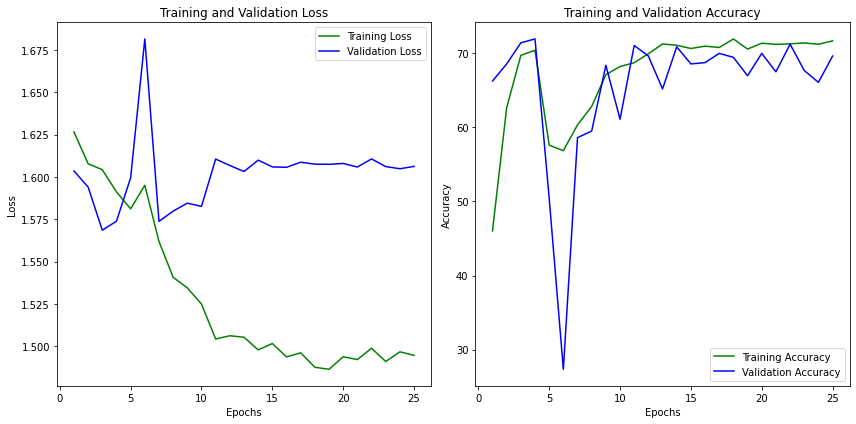


Epoch 26/50
-------------------------------
Epoch: 25, Learning Rate: 0.000000 
Batch 0/317 processed, running loss: 1.566395, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 103.561671, correct predictions: 837, total: 1136
Batch 140/317 processed, running loss: 208.442297, correct predictions: 1643, total: 2256
Batch 210/317 processed, running loss: 311.993430, correct predictions: 2457, total: 3376
Batch 280/317 processed, running loss: 417.451142, correct predictions: 3246, total: 4496

Training Loss per batch = 1.488622	Accuracy on Training set = 72.204662% [3655/5062]

Validation Loss per batch = 1.608027	Accuracy on Validation set = 70.337478% [396/563]
Train Loss: 1.4886, Train Accuracy: 72.2047
Valid Loss: 1.6080, Valid Accuracy: 70.3375


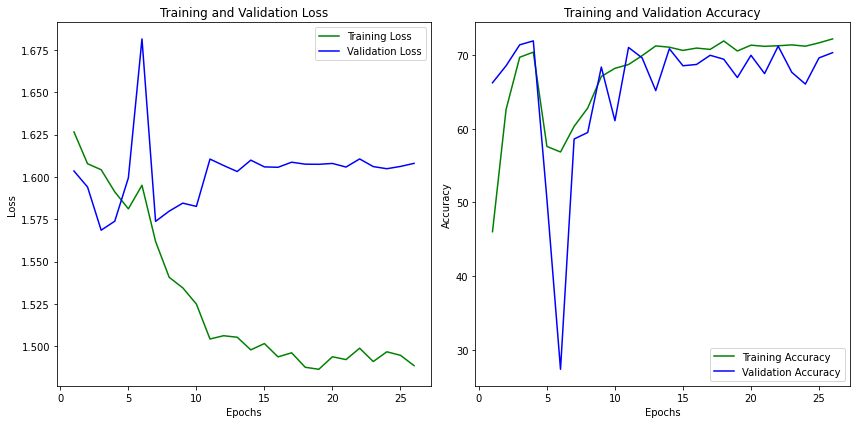


Epoch 27/50
-------------------------------
Epoch: 26, Learning Rate: 0.000000 
Batch 0/317 processed, running loss: 1.545711, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 102.906621, correct predictions: 839, total: 1136
Batch 140/317 processed, running loss: 205.697765, correct predictions: 1658, total: 2256
Batch 210/317 processed, running loss: 310.999191, correct predictions: 2463, total: 3376
Batch 280/317 processed, running loss: 414.411988, correct predictions: 3253, total: 4496

Training Loss per batch = 1.484999	Accuracy on Training set = 72.323192% [3661/5062]

Validation Loss per batch = 1.607281	Accuracy on Validation set = 67.850799% [382/563]
Train Loss: 1.4850, Train Accuracy: 72.3232
Valid Loss: 1.6073, Valid Accuracy: 67.8508


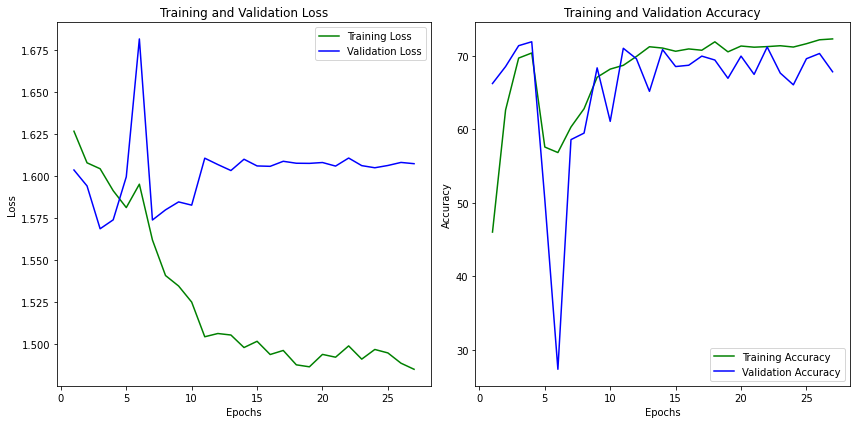


Epoch 28/50
-------------------------------
Epoch: 27, Learning Rate: 0.000000 
Batch 0/317 processed, running loss: 1.301948, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 105.777205, correct predictions: 791, total: 1136
Batch 140/317 processed, running loss: 208.665523, correct predictions: 1607, total: 2256
Batch 210/317 processed, running loss: 311.607288, correct predictions: 2418, total: 3376
Batch 280/317 processed, running loss: 417.287134, correct predictions: 3212, total: 4496

Training Loss per batch = 1.483955	Accuracy on Training set = 71.532991% [3621/5062]

Validation Loss per batch = 1.608039	Accuracy on Validation set = 67.495560% [380/563]
Train Loss: 1.4840, Train Accuracy: 71.5330
Valid Loss: 1.6080, Valid Accuracy: 67.4956


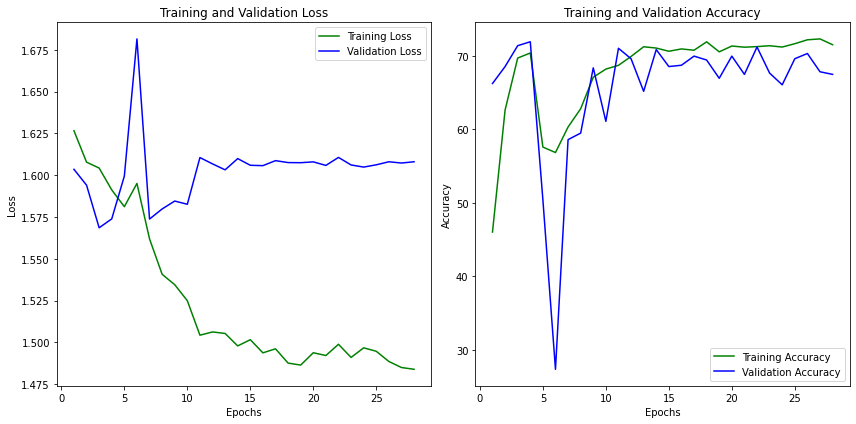


Epoch 29/50
-------------------------------
Epoch: 28, Learning Rate: 0.000000 
Batch 0/317 processed, running loss: 1.669992, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 105.892120, correct predictions: 815, total: 1136
Batch 140/317 processed, running loss: 209.387198, correct predictions: 1623, total: 2256


In [ ]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001, weight_decay=1e-5)
nb_epochs = 50
patience = 35

#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience)
